## VQ-VAE and Pixel CNN

Code: https://github.com/probml/pyprobml/tree/master/scripts/vae

## Installs


In [1]:
!pip install pytorch_lightning

     |████████████████████████████████| 916 kB 8.4 MB/s 
     |████████████████████████████████| 829 kB 34.1 MB/s 
     |████████████████████████████████| 118 kB 68.6 MB/s 
     |████████████████████████████████| 272 kB 79.7 MB/s 
     |████████████████████████████████| 636 kB 68.7 MB/s 
     |████████████████████████████████| 1.3 MB 55.1 MB/s 
     |████████████████████████████████| 142 kB 69.9 MB/s 
     |████████████████████████████████| 294 kB 65.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=8f5ee30dc4903db2cd014602f942d49aef969c78644b625953951dc8bb4c6162
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

## Clone 

In [2]:
!git clone 'https://github.com/probml/pyprobml.git'

Cloning into 'pyprobml'...
remote: Enumerating objects: 12678, done.
remote: Counting objects: 100% (1423/1423), done.
remote: Compressing objects: 100% (787/787), done.
remote: Total 12678 (delta 828), reused 1075 (delta 622), pack-reused 11255
Receiving objects: 100% (12678/12678), 607.57 MiB | 31.83 MiB/s, done.
Resolving deltas: 100% (7045/7045), done.


In [3]:
%cd '/content/pyprobml/scripts/vae'

/content/pyprobml/scripts/vae


## Imports

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Ftn
from torchvision.utils import make_grid
import os
from assembler import get_config, assembler
from experiment import *

## Load the pixelCNN  and vq-vae model checkpoints from probml-data bucket

In [5]:
from google.colab import auth
auth.authenticate_user()

In [6]:
bucket_name = 'probml_data'

In [7]:
!mkdir /content/pyprobml/scripts/vae/model 

In [8]:
!gsutil cp -r gs://{bucket_name}/vae_checkpoints /content/pyprobml/scripts/vae/model 

Copying gs://probml_data/vae_checkpoints/pixel_cnn_celeba_conv.ckpt...
Copying gs://probml_data/vae_checkpoints/vanilla_ae_celeba_conv.ckpt...
Copying gs://probml_data/vae_checkpoints/vq_vae_celeba_conv.ckpt...
| [3 files][126.0 MiB/126.0 MiB]                                                
Operation completed over 3 objects/126.0 MiB.                                    


In [9]:
config = get_config('./configs/vq_vae.yaml')
vae = assembler(config, "training")

In [10]:
vae.load_state_dict(torch.load(os.path.join('./model/vae_checkpoints/', config["pixel_params"]["pretrained_path"])))

<All keys matched successfully>

In [11]:
num_residual_blocks = config["pixel_params"]["num_residual_blocks"]
num_pixelcnn_layers = config["pixel_params"]["num_pixelcnn_layers"]
num_embeddings = config["vq_params"]["num_embeddings"]
hidden_dim = config["pixel_params"]["hidden_dim"]

In [12]:
pixel_cnn_raw = PixelCNN(hidden_dim, num_residual_blocks, num_pixelcnn_layers, num_embeddings)
pixel_cnn = PixelCNNModule(pixel_cnn_raw,
                            vae,
                            config["pixel_params"]["height"],
                            config["pixel_params"]["width"],
                            config["pixel_params"]["LR"])

In [13]:
pixel_cnn.load_state_dict(torch.load(os.path.join('./model/vae_checkpoints/', config["pixel_params"]["save_path"])))

<All keys matched successfully>

In [14]:
p_pixel_cnn = PixelCNNModule(pixel_cnn, vae, config["pixel_params"]["height"], config["pixel_params"]["width"],config["pixel_params"]["LR"])

## Get samples 

In [15]:
p_pixel_cnn = pixel_cnn.to("cuda")
N = 32
priors = p_pixel_cnn.get_priors(N)
generated_samples = p_pixel_cnn.generate_samples_from_priors(priors)

## Show grid


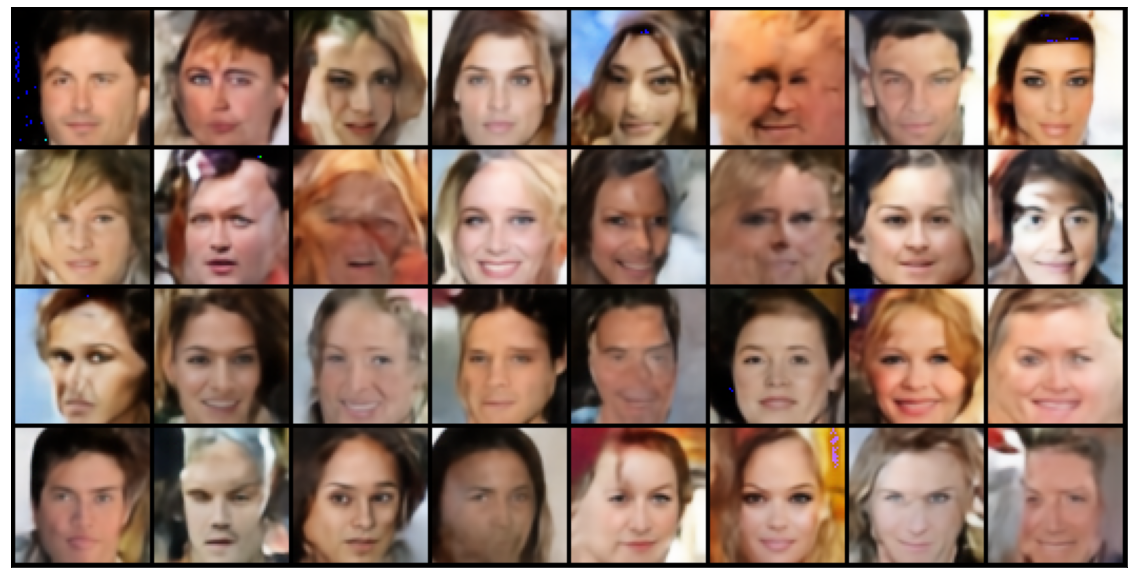

In [16]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = Ftn.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

grid = make_grid(generated_samples)
show(grid)

## Codebook Sampling

In [17]:
def generate_samples_from_priors_cpu(self, priors):
        priors = priors.to(self.device)
        priors_ohe = F.one_hot(priors.view(-1, 1).to("cpu").long(), num_classes=self.vector_quantizer.K).squeeze().float()
        quantized = torch.matmul(priors_ohe, self.vector_quantizer.embedding.weight)  # [BHW, D]
        quantized = quantized.view(-1, self.height, self.width, self.vector_quantizer.D).permute(0, 3, 1, 2)
        with torch.no_grad():
            return self.decoder(quantized)

In [18]:
p_pixel_cnn_cpu = pixel_cnn.to("cpu")
N = 16
priors = p_pixel_cnn.get_priors(N)

In [19]:
generated_cpu_samples = generate_samples_from_priors_cpu(p_pixel_cnn, priors)

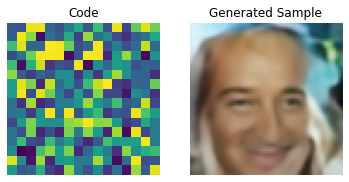

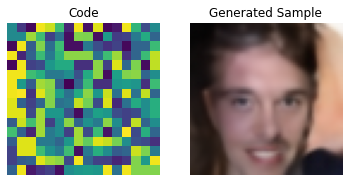

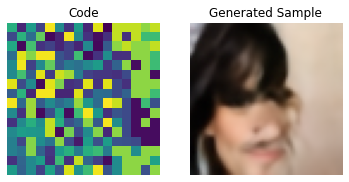

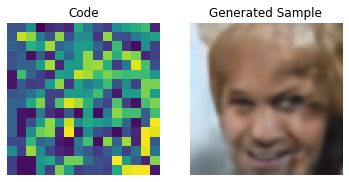

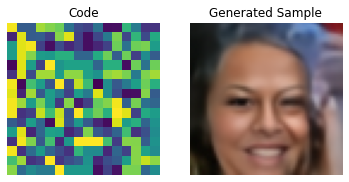

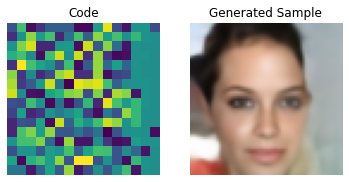

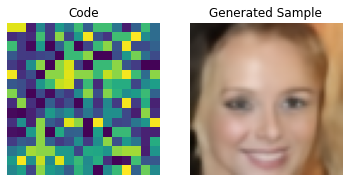

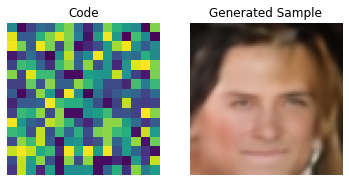

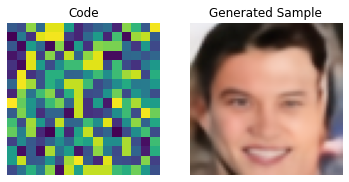

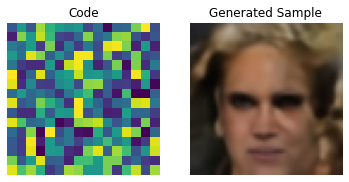

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


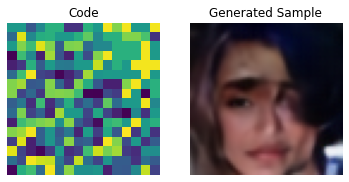

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


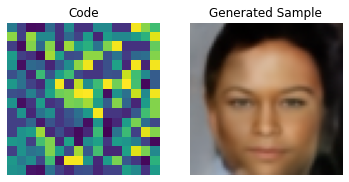

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


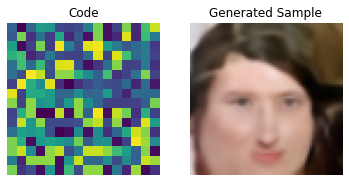

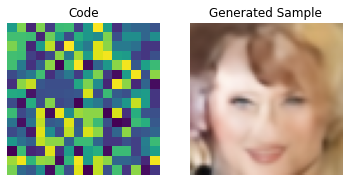

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


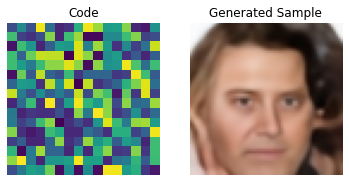

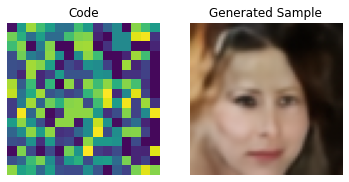

In [20]:
import matplotlib.pyplot as plt

for i in range(16):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i].detach().cpu())
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_cpu_samples[i].detach().permute(1,2,0).squeeze())
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()